<a href="https://colab.research.google.com/github/Anudeepsadda/AI-Powered-Powertrain-IDS-For-CAN-Networks/blob/main/car_can_security.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Mount Google Drive (gives access to your Drive inside Colab) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Base project path inside your Google Drive
base = '/content/drive/MyDrive/car-sec-project'

# Create subfolders
os.makedirs(base + '/data', exist_ok=True)     # For datasets
os.makedirs(base + '/models', exist_ok=True)   # For trained models
os.makedirs(base + '/notebooks', exist_ok=True) # For Colab notebooks
print("Project structure created at:", base)

Project structure created at: /content/drive/MyDrive/car-sec-project


In [ ]:
!pip -q install pandas numpy scikit-learn pyod matplotlib tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.8 MB/s eta 0:00:00


In [ ]:
import zipfile, os

data_path = '/content/drive/MyDrive/car-sec-project/data'
zip_path = os.path.join(data_path, 'In-Vehicle Network Intrusion Detection.zip')

# Extract files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

print("Files extracted to:", data_path)
os.listdir(data_path)

Files extracted to: /content/drive/MyDrive/car-sec-project/data


['In-Vehicle Network Intrusion Detection.zip',
 'In-Vehicle Network Intrusion Detection']

In [ ]:
import os

data_path = '/content/drive/MyDrive/car-sec-project/data/In-Vehicle Network Intrusion Detection'
os.listdir(data_path)

['car_track_final_1st_release',
 'car_track_final_1st_train',
 'car_track_final_2nd_release',
 'car_track_final_2nd_train',
 'car_track_preliminary_release',
 'car_track_preliminary_train']

In [ ]:
import os

data_path = '/content/drive/MyDrive/car-sec-project/data/In-Vehicle Network Intrusion Detection/car_track_final_1st_release'
os.listdir(data_path)

['File_1.csv', 'File_2.csv', 'File_3.csv', 'File_4.csv']

In [ ]:
import os

data_path = '/content/drive/MyDrive/car-sec-project/data/In-Vehicle Network Intrusion Detection/car_track_final_1st_train'
os.listdir(data_path)

['Attack_free_HY_Sonata_train.csv',
 'Attack_free_KIA_Soul_train.csv',
 'Fuzzy_dataset_HY_Sonata_train.csv',
 'Fuzzy_dataset_KIA_Soul_train.csv',
 'Malfunction_1st_dataset_HY_Sonata_train.csv',
 'Malfunction_1st_dataset_KIA_Soul_train.csv']

In [ ]:
import os

data_path = '/content/drive/MyDrive/car-sec-project/data/In-Vehicle Network Intrusion Detection/car_track_final_2nd_release'
os.listdir(data_path)

['File_1.csv', 'File_2.csv', 'File_3.csv', 'File_4.csv']

In [ ]:
import os

data_path = '/content/drive/MyDrive/car-sec-project/data/In-Vehicle Network Intrusion Detection/car_track_final_2nd_train'
os.listdir(data_path)

['Malfunction_2nd_HY_Sonata_train.csv',
 'Malfunction_2nd_KIA_Soul_train.csv',
 'Replay_dataset_HY_Sonata_train.csv',
 'Replay_dataset_KIA_Soul_train.csv']

In [ ]:
import os

data_path = '/content/drive/MyDrive/car-sec-project/data/In-Vehicle Network Intrusion Detection/car_track_preliminary_release'
os.listdir(data_path)

['File_1.csv',
 'File_3.csv',
 'File_2.csv',
 'File_4.csv',
 'File_8.csv',
 'File_7.csv',
 'File_9.csv']

In [ ]:
import os

data_path = '/content/drive/MyDrive/car-sec-project/data/In-Vehicle Network Intrusion Detection/car_track_preliminary_train'
os.listdir(data_path)

['Attack_free_CHEVROLET_Spark_train.csv',
 'Flooding_CHEVROLET_Spark_train.csv',
 'Attack_free_KIA_Soul_train.csv',
 'Attack_free_HYUNDAI_Sonata_train.csv',
 'Fuzzy_CHEVROLET_Spark_train.csv',
 'Flooding_KIA_Soul_train.csv',
 'Flooding_HYUNDAI_Sonata_train.csv',
 'Fuzzy_HYUNDAI_Sonata_train.csv',
 'Malfunction_HYUNDAI_Sonata_train.csv',
 'Malfunction_CHEVROLET_Spark_train.csv',
 'Fuzzy_KIA_Soul_train.csv',
 'Malfunction_KIA_Soul_train.csv']

In [ ]:
import os, pandas as pd

# Base dataset path (your Google Drive folder)
base_path = "/content/drive/MyDrive/car-sec-project/data/In-Vehicle Network Intrusion Detection"

In [ ]:
label_map = {
    'attack_free': 0,   # Normal
    'flooding': 1,      # DoS
    'fuzzy': 2,         # Random CAN IDs/data
    'replay': 3,        # Replay old frames
    'malfunction': 4    # Fault injection
}

In [ ]:
def load_dataset(folder_path):
    data_frames = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            fp = os.path.join(folder_path, file)
            df = pd.read_csv(fp)

            # Normalize column names
            df.columns = [c.strip().upper().replace(" ", "_") for c in df.columns]

            # Detect attack type from filename
            fname_lower = file.lower()
            for key, val in label_map.items():
                if key in fname_lower:
                    df['ATTACK_LABEL'] = val
                    break

            data_frames.append(df)
            print(f"Loaded {file} → shape {df.shape}")
    return pd.concat(data_frames, ignore_index=True)

In [ ]:
def clean_and_load(folder_path):
    data_frames = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            fp = os.path.join(folder_path, file)
            df = pd.read_csv(fp, header=None)  # no header in these files

            # Most CAN datasets = [Timestamp, CAN_ID, DLC, DataBytes...]
            # Keep only first 4 cols: Time, ID, DLC, Data
            df = df.iloc[:, 0:4]
            df.columns = ['TIMESTAMP', 'CAN_ID', 'DLC', 'DATA']

            # Add attack label
            fname_lower = file.lower()
            for key, val in label_map.items():
                if key in fname_lower:
                    df['ATTACK_LABEL'] = val
                    break

            data_frames.append(df)
            print(f"Loaded {file} → shape {df.shape}")
    return pd.concat(data_frames, ignore_index=True)

In [ ]:
train_path = os.path.join(base_path, "car_track_preliminary_train")

df_train = clean_and_load(train_path)

print("\nFinal merged shape:", df_train.shape)
print("\nColumns:", df_train.columns)
print("\nLabel distribution:\n", df_train['ATTACK_LABEL'].value_counts())
print("\nSample rows:\n", df_train.head(10))

Loaded Attack_free_CHEVROLET_Spark_train.csv → shape (136934, 5)
Loaded Flooding_CHEVROLET_Spark_train.csv → shape (85000, 5)
Loaded Attack_free_KIA_Soul_train.csv → shape (192516, 5)
Loaded Attack_free_HYUNDAI_Sonata_train.csv → shape (117173, 5)
Loaded Fuzzy_CHEVROLET_Spark_train.csv → shape (41000, 5)
Loaded Flooding_KIA_Soul_train.csv → shape (120000, 5)
Loaded Flooding_HYUNDAI_Sonata_train.csv → shape (96000, 5)
Loaded Fuzzy_HYUNDAI_Sonata_train.csv → shape (88000, 5)
Loaded Malfunction_HYUNDAI_Sonata_train.csv → shape (87000, 5)
Loaded Malfunction_CHEVROLET_Spark_train.csv → shape (51000, 5)
Loaded Fuzzy_KIA_Soul_train.csv → shape (144000, 5)
Loaded Malfunction_KIA_Soul_train.csv → shape (113000, 5)

Final merged shape: (1271623, 5)

Columns: Index(['TIMESTAMP', 'CAN_ID', 'DLC', 'DATA', 'ATTACK_LABEL'], dtype='object')

Label distribution:
 ATTACK_LABEL
0    446623
1    301000
2    273000
4    251000
Name: count, dtype: int64

Sample rows:
       TIMESTAMP CAN_ID  DLC            

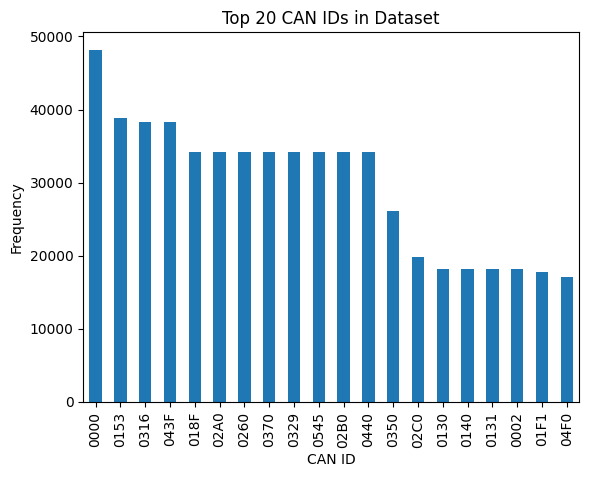

In [ ]:
import matplotlib.pyplot as plt

if 'CAN_ID' in df_train.columns:
    df_train['CAN_ID'].value_counts().head(20).plot(kind='bar')
    plt.title("Top 20 CAN IDs in Dataset")
    plt.xlabel("CAN ID")
    plt.ylabel("Frequency")
    plt.show()

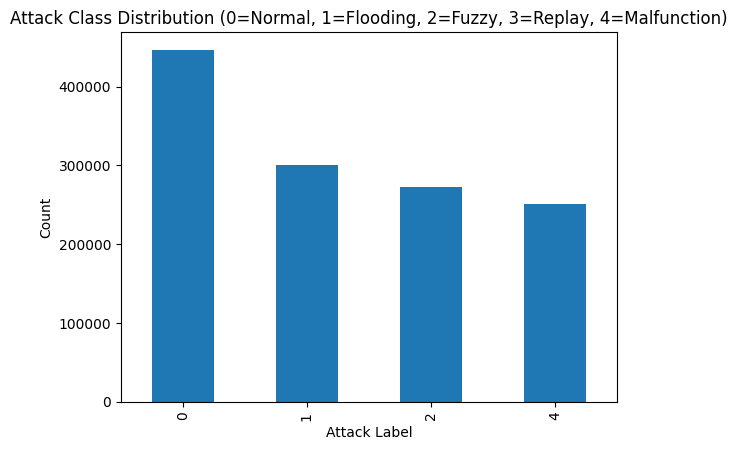

In [ ]:
df_train['ATTACK_LABEL'].value_counts().sort_index().plot(kind='bar')
plt.title("Attack Class Distribution (0=Normal, 1=Flooding, 2=Fuzzy, 3=Replay, 4=Malfunction)")
plt.xlabel("Attack Label")
plt.ylabel("Count")
plt.show()

In [ ]:
# Load replay + malfunction from final_2nd_train
train_path_final2 = os.path.join(base_path, "car_track_final_2nd_train")

df_final2 = clean_and_load(train_path_final2)

print("Final 2nd train shape:", df_final2.shape)
print("Label distribution:\n", df_final2['ATTACK_LABEL'].value_counts())

# Combine with previous training set
df_all = pd.concat([df_train, df_final2], ignore_index=True)

print("\nMerged full dataset shape:", df_all.shape)
print("\nLabel distribution across all attacks:\n", df_all['ATTACK_LABEL'].value_counts())

Loaded Malfunction_2nd_HY_Sonata_train.csv → shape (419689, 5)
Loaded Malfunction_2nd_KIA_Soul_train.csv → shape (400530, 5)
Loaded Replay_dataset_HY_Sonata_train.csv → shape (530618, 5)
Loaded Replay_dataset_KIA_Soul_train.csv → shape (566338, 5)
Final 2nd train shape: (1917175, 5)
Label distribution:
 ATTACK_LABEL
3    1096956
4     820219
Name: count, dtype: int64

Merged full dataset shape: (3188798, 5)

Label distribution across all attacks:
 ATTACK_LABEL
3    1096956
4    1071219
0     446623
1     301000
2     273000
Name: count, dtype: int64


In [ ]:
import numpy as np

# Copy dataset to avoid changes on original
df_ml = df_all.copy()

# Convert CAN_ID from hex to integer
def hex_to_int(x):
    try:
        return int(str(x), 16)
    except:
        return np.nan

df_ml['CAN_ID_INT'] = df_ml['CAN_ID'].apply(hex_to_int)

In [ ]:
# Split DATA into 8 bytes
data_bytes = df_ml['DATA'].str.split(' ', expand=True)
data_bytes.columns = [f'DATA{i}' for i in range(data_bytes.shape[1])]

# Merge back
df_ml = pd.concat([df_ml, data_bytes], axis=1)

# Fill missing with 0
df_ml = df_ml.fillna('0')

# Convert all data byte columns to integers
for col in ['DLC'] + list(data_bytes.columns):
    df_ml[col] = df_ml[col].apply(lambda x: int(str(x), 16) if isinstance(x, str) else int(x))

# Final feature set
feature_cols = ['CAN_ID_INT', 'DLC'] + list(data_bytes.columns)
X = df_ml[feature_cols]
y = df_ml['ATTACK_LABEL']

print("Features shape:", X.shape)
print("Labels distribution:\n", y.value_counts())

Features shape: (3188798, 10)
Labels distribution:
 ATTACK_LABEL
3    1096956
4    1071219
0     446623
1     301000
2     273000
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Sample 200k rows for faster training (you can increase later)
df_sample = df_ml.sample(n=200000, random_state=42)

X = df_sample[feature_cols]
y = df_sample['ATTACK_LABEL']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (140000, 10) Test size: (60000, 10)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
print("Random Forest trained")

Random Forest trained


              precision    recall  f1-score   support

           0     0.6229    0.7179    0.6670      8395
           1     0.7559    0.4647    0.5756      5631
           2     0.9039    0.5418    0.6775      5209
           3     0.6340    0.9529    0.7614     20647
           4     0.8679    0.5482    0.6720     20118

    accuracy                         0.7028     60000
   macro avg     0.7569    0.6451    0.6707     60000
weighted avg     0.7457    0.7028    0.6935     60000



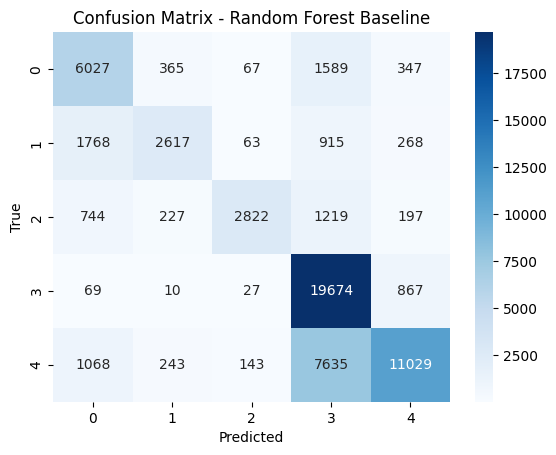

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = rf.predict(X_test)

# Report
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3,4],
            yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest Baseline")
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Use subset for speed
df_seq = df_all.sample(n=200000, random_state=42)

# Convert CAN_ID to int
df_seq['CAN_ID_INT'] = df_seq['CAN_ID'].apply(lambda x: int(str(x), 16) if isinstance(x, str) else int(x))

# Split DATA into 8 bytes
data_bytes = df_seq['DATA'].str.split(' ', expand=True).fillna('00')
data_bytes.columns = [f'DATA{i}' for i in range(8)]

# Convert hex to int
for col in data_bytes.columns:
    data_bytes[col] = data_bytes[col].apply(lambda x: int(str(x), 16))

# Merge features
X_features = pd.concat([df_seq[['CAN_ID_INT','DLC']], data_bytes], axis=1)
y_labels = df_seq['ATTACK_LABEL'].values

# Normalize features
X_features = X_features.values / 255.0

In [ ]:
SEQ_LEN = 20  # window size

def create_sequences(X, y, seq_len=SEQ_LEN):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_features, y_labels, SEQ_LEN)

print("Sequences shape:", X_seq.shape, y_seq.shape)

Sequences shape: (199980, 20, 10) (199980,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.3, stratify=y_seq, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (139986, 20, 10) Test: (59994, 20, 10)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_classes = len(np.unique(y_seq))

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,053 (133.02 KB)

 Trainable params: 34,053 (133.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3340 - loss: 1.4539 - val_accuracy: 0.3426 - val_loss: 1.4446
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3396 - loss: 1.4468 - val_accuracy: 0.3352 - val_loss: 1.4447
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3397 - loss: 1.4450 - val_accuracy: 0.3426 - val_loss: 1.4452
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.3409 - loss: 1.4445 - val_accuracy: 0.3426 - val_loss: 1.4456
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3409 - loss: 1.4447 - val_accuracy: 0.3426 - val_loss: 1.4450
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3409 - loss: 1.4432 - val_accuracy: 0.3426 - val_loss: 1.4449
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3433 - loss: 1.4414 - val_accuracy: 0.3426 - val_loss: 1.4451
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3437 - loss: 1.4435 - val_accur

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, digits=4))

Test Accuracy: 0.3353
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      8394
           1     0.0000    0.0000    0.0000      5631
           2     0.0000    0.0000    0.0000      5208
           3     0.0000    0.0000    0.0000     20645
           4     0.3353    1.0000    0.5022     20116

    accuracy                         0.3353     59994
   macro avg     0.0671    0.2000    0.1004     59994
weighted avg     0.1124    0.3353    0.1684     59994



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np

# Sample dataset for training speed
df_sample = df_all.sample(n=200000, random_state=42)

# Convert CAN_ID
df_sample['CAN_ID_INT'] = df_sample['CAN_ID'].apply(lambda x: int(str(x), 16) if isinstance(x, str) else int(x))

# Split DATA into 8 bytes
data_bytes = df_sample['DATA'].str.split(' ', expand=True).fillna('00')
data_bytes.columns = [f'DATA{i}' for i in range(8)]

for col in data_bytes.columns:
    data_bytes[col] = data_bytes[col].apply(lambda x: int(str(x), 16))

# Merge features
X = pd.concat([df_sample[['CAN_ID_INT','DLC']], data_bytes], axis=1)
y = df_sample['ATTACK_LABEL'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",   # faster
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=200,
    max_depth=-1,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 10
[LightGBM] [Info] Start training from score -1.966725
[LightGBM] [Info] Start training from score -2.365981
[LightGBM] [Info] Start training from score -2.444066
[LightGBM] [Info] Start training from score -1.066781
[LightGBM] [Info] Start training from score -1.092708


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gbdt.fit(X_train, y_train)
gbdt_pred = gbdt.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print("=== Random Forest ===")
print(classification_report(y_test, rf_pred, digits=4))

print("=== XGBoost ===")
print(classification_report(y_test, xgb_pred, digits=4))

print("=== LightGBM ===")
print(classification_report(y_test, lgbm_pred, digits=4))

print("=== Gradient Boosted DT ===")
print(classification_report(y_test, gbdt_pred, digits=4))

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.6242    0.7149    0.6665      8395
           1     0.7570    0.4635    0.5750      5631
           2     0.8869    0.5448    0.6750      5209
           3     0.6342    0.9520    0.7612     20647
           4     0.8671    0.5492    0.6725     20118

    accuracy                         0.7026     60000
   macro avg     0.7538    0.6449    0.6700     60000
weighted avg     0.7443    0.7026    0.6932     60000

=== XGBoost ===
              precision    recall  f1-score   support

           0     0.6237    0.7115    0.6647      8395
           1     0.7443    0.4720    0.5777      5631
           2     0.8763    0.5496    0.6756      5209
           3     0.6388    0.9384    0.7601     20647
           4     0.8496    0.5596    0.6748     20118

    accuracy                         0.7022     60000
   macro avg     0.7465    0.6462    0.6706     60000
weighted avg     0.7379    0.7022    0.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

print("Class Weights:", class_weights)

Class Weights: {np.int64(0): np.float64(1.4294465999591586), np.int64(1): np.float64(2.13089802130898), np.int64(2): np.float64(2.303957870484654), np.int64(3): np.float64(0.5812022583859183), np.int64(4): np.float64(0.5964680570053043)}


In [ ]:
# Add byte sum/mean
df_sample['BYTE_SUM'] = data_bytes.sum(axis=1)
df_sample['BYTE_MEAN'] = data_bytes.mean(axis=1)

# Message frequency (counts of each CAN_ID in sample)
id_counts = df_sample['CAN_ID_INT'].value_counts().to_dict()
df_sample['CAN_ID_FREQ'] = df_sample['CAN_ID_INT'].map(id_counts)

# Update feature set
X = pd.concat([df_sample[['CAN_ID_INT','DLC','BYTE_SUM','BYTE_MEAN','CAN_ID_FREQ']], data_bytes], axis=1)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Sample for speed
df_cnn = df_all.sample(n=200000, random_state=42)

# CAN_ID to int
df_cnn['CAN_ID_INT'] = df_cnn['CAN_ID'].apply(lambda x: int(str(x), 16) if isinstance(x, str) else int(x))

# Split DATA into bytes
data_bytes = df_cnn['DATA'].str.split(' ', expand=True).fillna('00')
data_bytes.columns = [f'DATA{i}' for i in range(8)]
for col in data_bytes.columns:
    data_bytes[col] = data_bytes[col].apply(lambda x: int(str(x), 16))

# Final features (normalize 0–255)
X = pd.concat([df_cnn[['CAN_ID_INT','DLC']], data_bytes], axis=1).values
X = X / 255.0

y = df_cnn['ATTACK_LABEL'].values
num_classes = len(np.unique(y))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Reshape for CNN (samples, timesteps, features=1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,885 (167.52 KB)

 Trainable params: 42,501 (166.02 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    epochs=15,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4240 - loss: 1.3546 - val_accuracy: 0.3712 - val_loss: 1.4427
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5121 - loss: 1.0984 - val_accuracy: 0.5304 - val_loss: 1.0407
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5375 - loss: 1.0327 - val_accuracy: 0.5543 - val_loss: 0.9984
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5532 - loss: 0.9942 - val_accuracy: 0.5663 - val_loss: 0.9727
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5648 - loss: 0.9696 - val_accuracy: 0.5559 - val_loss: 0.9667
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5725 - loss: 0.9467 - val_accuracy: 0.5680 - val_loss: 0.9439
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5731 - loss: 0.9396 - val_accuracy: 0.5759 - val_loss: 0.9334
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5819 - loss: 0.9229 - val_accuracy: 

In [ ]:
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, digits=4))

Test Accuracy: 0.6034
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

           0     0.5358    0.6554    0.5896      8395
           1     0.8171    0.3118    0.4514      5631
           2     0.8901    0.4275    0.5776      5209
           3     0.5523    0.9398    0.6957     20647
           4     0.7351    0.3635    0.4865     20118

    accuracy                         0.6034     60000
   macro avg     0.7061    0.5396    0.5602     60000
weighted avg     0.6655    0.6034    0.5775     60000



In [ ]:
import numpy as np
import pandas as pd

# Sample for training speed
df_hybrid = df_all.sample(n=200000, random_state=42)

# Convert CAN_ID
df_hybrid['CAN_ID_INT'] = df_hybrid['CAN_ID'].apply(lambda x: int(str(x), 16) if isinstance(x, str) else int(x))

# Split DATA into bytes
data_bytes = df_hybrid['DATA'].str.split(' ', expand=True).fillna('00')
data_bytes.columns = [f'DATA{i}' for i in range(8)]
for col in data_bytes.columns:
    data_bytes[col] = data_bytes[col].apply(lambda x: int(str(x), 16))

# Time delta (sorted by timestamp)
df_hybrid = df_hybrid.sort_values("TIMESTAMP")
df_hybrid['TIME_DELTA'] = df_hybrid['TIMESTAMP'].diff().fillna(0)

# CAN_ID frequency
id_counts = df_hybrid['CAN_ID_INT'].value_counts().to_dict()
df_hybrid['CAN_ID_FREQ'] = df_hybrid['CAN_ID_INT'].map(id_counts)

# Byte entropy
import math
def byte_entropy(data_str):
    bytes_list = data_str.split()
    if not bytes_list:
        return 0
    counts = {}
    for b in bytes_list:
        counts[b] = counts.get(b, 0) + 1
    probs = [c/len(bytes_list) for c in counts.values()]
    return -sum(p * math.log2(p) for p in probs)
df_hybrid['BYTE_ENTROPY'] = df_hybrid['DATA'].apply(byte_entropy)

# Rolling stats
df_hybrid['BYTE_SUM'] = data_bytes.sum(axis=1)
df_hybrid['BYTE_MEAN'] = data_bytes.mean(axis=1)
df_hybrid['BYTE_STD'] = data_bytes.std(axis=1)

# Final feature matrix
X = pd.concat([
    df_hybrid[['CAN_ID_INT','DLC','TIME_DELTA','CAN_ID_FREQ','BYTE_ENTROPY','BYTE_SUM','BYTE_MEAN','BYTE_STD']],
    data_bytes
], axis=1).values

y = df_hybrid['ATTACK_LABEL'].values

In [ ]:
SEQ_LEN = 20

def create_sequences(X, y, seq_len=SEQ_LEN):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

print("Sequences shape:", X_seq.shape, y_seq.shape)

Sequences shape: (199980, 20, 16) (199980,)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_seq))

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.3, stratify=y_seq, random_state=42
)

# One-hot labels
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (139986, 20, 16) Test: (59994, 20, 16)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Flatten

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 18, 64)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,981 (339.77 KB)

 Trainable params: 86,597 (338.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5678 - loss: 1.0945 - val_accuracy: 0.5899 - val_loss: 0.9378
Epoch 2/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7043 - loss: 0.7330 - val_accuracy: 0.5531 - val_loss: 1.3824
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7394 - loss: 0.6155 - val_accuracy: 0.6933 - val_loss: 0.7750
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7605 - loss: 0.5510 - val_accuracy: 0.7243 - val_loss: 0.6432
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7779 - loss: 0.5051 - val_accuracy: 0.7757 - val_loss: 0.5315
Epoch 6/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7981 - loss: 0.4653 - val_accuracy: 0.7647 - val_loss: 0.5370
Epoch 7/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8086 - loss: 0.4393 - val_accuracy: 0.7676 - val_loss: 0.5638
Epoch 8/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8253 - loss: 0.4024 - val

In [ ]:
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

Test Accuracy: 0.8226
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0     0.7785    0.7246    0.7506      8389
           1     0.9138    0.8807    0.8969      5631
           2     0.5671    0.7284    0.6377      5209
           3     0.8697    0.9482    0.9073     20647
           4     0.8509    0.7427    0.7931     20118

    accuracy                         0.8226     59994
   macro avg     0.7960    0.8049    0.7971     59994
weighted avg     0.8285    0.8226    0.8227     59994



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

history = model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8665 - loss: 0.3249 - val_accuracy: 0.8106 - val_loss: 0.4679
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8693 - loss: 0.3096 - val_accuracy: 0.8255 - val_loss: 0.4208
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8708 - loss: 0.2973 - val_accuracy: 0.8219 - val_loss: 0.4773
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8709 - loss: 0.2924 - val_accuracy: 0.8244 - val_loss: 0.4471
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8776 - loss: 0.2763 - val_accuracy: 0.8103 - val_loss: 0.5036
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8772 - loss: 0.2804 - val_accuracy: 0.8040 - val_loss: 0.5106
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8822 - loss: 0.2660 - val_accuracy: 0.8241 - val_loss: 0.4951
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8809 - loss: 0.2682 - val_a

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

history = model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9013 - loss: 0.2187 - val_accuracy: 0.8272 - val_loss: 0.4585
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9026 - loss: 0.2131 - val_accuracy: 0.8333 - val_loss: 0.4667
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8972 - loss: 0.2231 - val_accuracy: 0.8304 - val_loss: 0.5037
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9043 - loss: 0.2126 - val_accuracy: 0.8189 - val_loss: 0.4870
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9038 - loss: 0.2106 - val_accuracy: 0.7338 - val_loss: 0.8496
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9062 - loss: 0.2062 - val_accuracy: 0.8148 - val_loss: 0.5185
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9089 - loss: 0.2009 - val_accuracy: 0.7542 - val_loss: 0.8014
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9071 - loss: 0.2029 - val_acc

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, Flatten
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D, Embedding
from tensorflow.keras.models import Model

SEQ_LEN = 20
FEATURE_DIM = X_train.shape[2]
NUM_CLASSES = len(np.unique(y_train))

In [ ]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward layer
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x + x_ff)
    return x

In [ ]:
# Input
inputs = Input(shape=(SEQ_LEN, FEATURE_DIM))

# 2 Transformer blocks
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)

# Global pooling
x = GlobalAveragePooling1D()(x)

In [ ]:
# Dense layers
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 20, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 16)    │     17,168 │ input_layer_3[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 20, 16)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 16)    │          0 │ dropout_6[0][0],  │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 16)    │         32 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 20, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 20, 128)   │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 20, 16)    │      2,064 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 16)    │         32 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 16)    │     17,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 20, 16)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 20, 16)    │          0 │ dropout_9[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 16)    │         32 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 20, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 20, 128)   │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 20, 16)    │      2,064 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 20, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 16)    │         32 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 45,765 (178.77 KB)

 Trainable params: 45,765 (178.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback_list = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weights,  # from Phase 6 balancing
    callbacks=callback_list,
    verbose=1
)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.4189 - loss: 1.3748 - val_accuracy: 0.6426 - val_loss: 1.0252 - learning_rate: 0.0010
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6152 - loss: 1.0583 - val_accuracy: 0.6865 - val_loss: 0.8689 - learning_rate: 0.0010
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6694 - loss: 0.9090 - val_accuracy: 0.7119 - val_loss: 0.7601 - learning_rate: 0.0010
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6944 - loss: 0.8108 - val_accuracy: 0.7326 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7112 - loss: 0.7263 - val_accuracy: 0.7165 - val_loss: 0.6980 - learning_rate: 0.0010
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7180 - loss: 0.6872 - val_accuracy: 0.7406 - val_loss: 0.6335 - learning_rate: 0.0010
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7358 - loss: 0.6307 

In [ ]:
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))


Test Accuracy: 0.8422
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

           0     0.8736    0.7610    0.8134      8389
           1     0.9273    0.9711    0.9486      5631
           2     0.5404    0.9687    0.6938      5209
           3     0.8615    0.9751    0.9148     20647
           4     0.9585    0.6708    0.7892     20118

    accuracy                         0.8422     59994
   macro avg     0.8322    0.8693    0.8320     59994
weighted avg     0.8740    0.8422    0.8425     59994



In [ ]:
# After defining CNN+LSTM model
model_lstm = model  # rename it before training

history_lstm = model_lstm.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8330 - loss: 0.3626 - val_accuracy: 0.8416 - val_loss: 0.3414
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8401 - loss: 0.3467 - val_accuracy: 0.8511 - val_loss: 0.3125
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8420 - loss: 0.3409 - val_accuracy: 0.8545 - val_loss: 0.3167
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8408 - loss: 0.3384 - val_accuracy: 0.8552 - val_loss: 0.3013
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8449 - loss: 0.3343 - val_accuracy: 0.8534 - val_loss: 0.3117
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8482 - loss: 0.3261 - val_accuracy: 0.8541 - val_loss: 0.3038
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8511 - loss: 0.3207 - val_accuracy: 0.8566 - val_loss: 0.2947
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8542 - loss: 0.3114 - val_accuracy: 

In [ ]:
# After defining Transformer model
model_trans = model  # rename it before training

history_trans = model_trans.fit(
    X_train, y_train_cat,
    epochs=25,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/25
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8867 - loss: 0.2374 - val_accuracy: 0.8749 - val_loss: 0.2578
Epoch 2/25
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8861 - loss: 0.2386 - val_accuracy: 0.9030 - val_loss: 0.1939
Epoch 3/25
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8838 - loss: 0.2386 - val_accuracy: 0.8833 - val_loss: 0.2363
Epoch 4/25
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8853 - loss: 0.2384 - val_accuracy: 0.8923 - val_loss: 0.2175
Epoch 5/25
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8865 - loss: 0.2313 - val_accuracy: 0.8871 - val_loss: 0.2332
Epoch 6/25
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8877 - loss: 0.2334 - val_accuracy: 0.8866 - val_loss: 0.2330
Epoch 7/25
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8873 - loss: 0.2346 - val_accuracy: 0.9011 - val_loss: 0.1975
Epoch 8/25
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8897 - loss: 0.2296 - val_accuracy: 0

In [64]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Get probability predictions from both models
y_pred_proba_lstm = model_lstm.predict(X_test)
y_pred_proba_trans = model_trans.predict(X_test)

# Average probabilities
y_pred_proba_fusion = (y_pred_proba_lstm + y_pred_proba_trans) / 2.0

# Final prediction = class with highest probability
y_pred_fusion = np.argmax(y_pred_proba_fusion, axis=1)

# Evaluate
print("Fusion Accuracy:", accuracy_score(y_test, y_pred_fusion))
print(classification_report(y_test, y_pred_fusion, digits=4))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Fusion Accuracy: 0.9014401440144014
              precision    recall  f1-score   support

           0     0.8986    0.7647    0.8262      8389
           1     0.9928    0.9842    0.9885      5631
           2     0.5839    0.9414    0.7208      5209
           3     0.9702    0.9809    0.9755     20647
           4     0.9427    0.8434    0.8903     20118

    accuracy                         0.9014     59994
   macro avg     0.8776    0.9029    0.8803     59994
weighted avg     0.9195    0.9014    0.9052     59994



PREDICTIONS

In [65]:
import numpy as np

# Pick 10 random samples from test data
idx = np.random.choice(len(X_test), 10, replace=False)
X_sample = X_test[idx]
y_true_sample = y_test[idx]

In [66]:
# Get probability predictions
proba_lstm = model_lstm.predict(X_sample)
proba_trans = model_trans.predict(X_sample)

# Fusion: average of both
proba_fusion = (proba_lstm + proba_trans) / 2.0

# Final predictions
y_pred_sample = np.argmax(proba_fusion, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [67]:
label_map = {
    0: "Normal",
    1: "Flooding Attack",
    2: "Fuzzy Attack",
    3: "Replay Attack",
    4: "Malfunction Attack"
}

print("\n Sample Predictions:")
for i in range(len(y_pred_sample)):
    print(f"Message {i+1}: True = {label_map[y_true_sample[i]]}, Predicted = {label_map[y_pred_sample[i]]}")



 Sample Predictions:
Message 1: True = Fuzzy Attack, Predicted = Fuzzy Attack
Message 2: True = Normal, Predicted = Normal
Message 3: True = Fuzzy Attack, Predicted = Malfunction Attack
Message 4: True = Replay Attack, Predicted = Replay Attack
Message 5: True = Replay Attack, Predicted = Replay Attack
Message 6: True = Malfunction Attack, Predicted = Malfunction Attack
Message 7: True = Normal, Predicted = Normal
Message 8: True = Replay Attack, Predicted = Replay Attack
Message 9: True = Flooding Attack, Predicted = Flooding Attack
Message 10: True = Flooding Attack, Predicted = Flooding Attack


In [68]:
import pandas as pd

# Pick one sample for each attack type
sample_normal = X_test[y_test == 0][0].reshape(1, -1, X_test.shape[2])
sample_flooding = X_test[y_test == 1][0].reshape(1, -1, X_test.shape[2])
sample_fuzzy = X_test[y_test == 2][0].reshape(1, -1, X_test.shape[2])
sample_replay = X_test[y_test == 3][0].reshape(1, -1, X_test.shape[2])
sample_malfunction = X_test[y_test == 4][0].reshape(1, -1, X_test.shape[2])

targeted_samples = [
    ("Normal", sample_normal, 0),
    ("Flooding", sample_flooding, 1),
    ("Fuzzy", sample_fuzzy, 2),
    ("Replay", sample_replay, 3),
    ("Malfunction", sample_malfunction, 4),
]

In [74]:
def predict_fusion(sample):
    proba_lstm = model_lstm.predict(sample)
    proba_trans = model_trans.predict(sample)
    proba_fusion = (proba_lstm + proba_trans) / 2.0
    return np.argmax(proba_fusion, axis=1)[0]

print("\n Targeted Predictions:")
for name, sample, true_label in targeted_samples:
    pred = predict_fusion(sample)
    print(f"True: {name:12} | Predicted: {label_map[pred]}")


 Targeted Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
True: Normal       | Predicted: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
True: Flooding     | Predicted: Flooding Attack
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
True: Fuzzy        | Predicted: Fuzzy Attack
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
True: Replay       | Predicted: Replay Attack
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
True: Malfunction  | Predicted: Malfunction Attack


In [75]:
import tensorflow as tf
from tensorflow import keras

# Assume 'model' is your trained Keras model
# Example: Create a simple model for demonstration
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(10,)),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model (optional for saving, but necessary for training)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Save the model to an .h5 file
model.save('my_model.h5')

print("Model saved successfully as my_model.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model saved successfully as my_model.h5
